<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/augmentation/cutout_cutmix_mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Augmentacja danych: CutOut, CutMix, MixUp

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.fashion_mnist import load_data
import tensorflow as tf
import random

In [6]:
(X_train, y_train), (X_test, y_test) = load_data()

4423680/4422102 [==============================] - 0s 0us/step


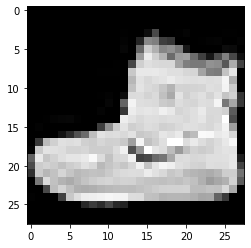

In [7]:
plt.imshow(X_train[0], cmap='gray')

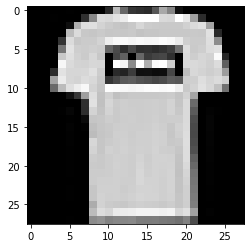

In [8]:
plt.imshow(X_train[1], cmap='gray')

##CutOut

In [9]:
def cutout(img, n_patches=1, patch_width=16, patch_height=16):
  h = img.shape[0]
  w = img.shape[1]

  mask = np.ones((h, w), np.float32)

  for _ in range(n_patches):
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - patch_height // 2, 0, h)
    y2 = np.clip(y + patch_height // 2, 0, h)
    x1 = np.clip(x - patch_width // 2, 0, w)
    x2 = np.clip(x + patch_width // 2, 0, w)

    mask[y1:y2, x1:x2] = 0

  img = img * mask
  return img

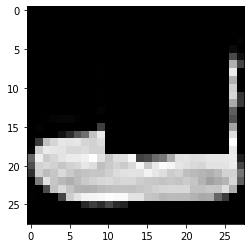

In [ ]:
out = cutout(X_train[0])
plt.imshow(out, cmap='gray')

#CutMix

In [10]:
def cutmix(img1, img2, n_patches=1, patch_width=16, patch_height=16):
  h = img1.shape[0]
  w = img1.shape[1]

  img = np.array(img1)
  mask = np.zeros((patch_height, patch_width))

  for _ in range(n_patches):
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - patch_height // 2, 0, h)
    y2 = np.clip(y + patch_height // 2, 0, h)
    x1 = np.clip(x - patch_width // 2, 0, w)
    x2 = np.clip(x + patch_width // 2, 0, w)

    mask = img2[y1:y2, x1:x2]
    img[y1:y2, x1:x2] = mask

  return img

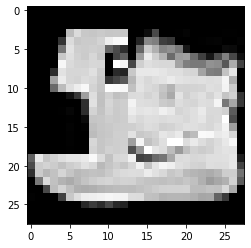

In [ ]:
mix = cutmix(X_train[0], X_train[1], n_patches=1)
plt.imshow(mix, cmap='gray')

#MixUp

In [11]:
# Lambda spróbkowana z rozkładu beta
# Zwiększone prawdopodobieństwo wylosowania wartości 
# z krańców przedziału <0, 1> dla małego alpha
alpha = 0.2
l = np.random.beta(alpha, alpha)
print(l)

0.9826668410120584


In [12]:
def mixup(img1, label1, img2, label2, alpha=0.2):
  label1 = tf.one_hot(label1, 10)
  label2 = tf.one_hot(label2, 10)

  l = np.random.beta(alpha, alpha)

  img = l * img1 + (1 - l) * img2
  label = l * label1 + (1 - l) * label2

  return (img, label)

tf.Tensor(
[0.9792946  0.         0.         0.         0.         0.
 0.         0.         0.         0.02070543], shape=(10,), dtype=float32)


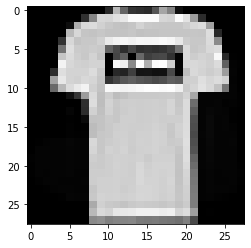

In [ ]:
(img, label) = mixup(X_train[0], y_train[0], X_train[1], y_train[1])
plt.imshow(img, cmap='gray')
print(label)

tf.Tensor(
[0.3741765 0.        0.        0.        0.        0.        0.
 0.        0.        0.6258235], shape=(10,), dtype=float32)


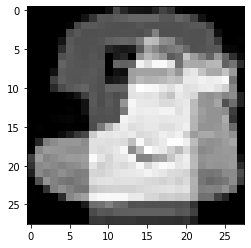

In [ ]:
(img, label) = mixup(X_train[0], y_train[0], X_train[1], y_train[1], alpha=1)
plt.imshow(img, cmap='gray')
print(label)

In [19]:
def augment(images, labels, method, samples_per_input=1):

  assert images.shape[0] == labels.shape[0]
  dataset_length = images.shape[0]
  w = images.shape[1]
  h = images.shape[2]

  X_aug = []  # np.array((dataset_length * samples_per_input, w, h))
  y_aug = []  # np.array(dataset_length * samples_per_input)

  # Ustawienie szerokości i wysokości łaty dla cutout i cutmix na pół obrazka
  patch_w = int(images.shape[1] / 2)
  patch_h = int(images.shape[2] / 2)

  for _ in range(samples_per_input):
    for i in range(dataset_length):

      if method == 'cutout':
        X = cutout(images[i], n_patches=1, patch_width=patch_w, patch_height=patch_h)
        y = labels[i]

      elif method == 'cutmix':
        j = random.randint(0, dataset_length - 1)
        X = cutmix(images[i], images[j], n_patches=1, patch_width=patch_w, patch_height=patch_h)
        y = labels[i]

      elif method == 'mixup':
        j = random.randint(0, dataset_length - 1)
        X, y = mixup(images[i], labels[i], images[j], labels[j])

      else:
        print('Method parameter accepts only 3 arguments: "cutout", "cutmix" or "mixup".')

      X_aug.append(X)
      y_aug.append(y)

  X_aug = np.array(X_aug)
  y_aug = np.array(y_aug)
  return (X_aug, y_aug)

In [22]:
(X_aug, y_aug) = augment(X_train[:10], y_train[:10], method='cutout')

print(X_aug.shape)
print(y_aug.shape)

(10, 28, 28)
(10,)


9


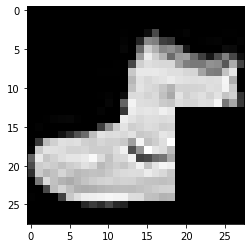

In [23]:
plt.imshow(X_aug[0], cmap='gray')
print(y_aug[0])

In [20]:
(X_aug, y_aug) = augment(X_train[:10], y_train[:10], method='cutmix')

In [21]:
(X_aug, y_aug) = augment(X_train[:10], y_train[:10], method='mixup')